# Integrating gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates how to apply `MuVI` on multiple modalities, e.g. RNA-seq and ATAC-seq, in order to infer a joint latent space that is informed a priori by existing domain knowledge in terms of gene set annotations.

This tutorial extends the excellent [muon-tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.html) on applying [MOFA](https://biofam.github.io/MOFA2/) to single-cell gene expression and chromatin accessibility for inferring a joint latent space across multiple modalities.
Please refer to [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.html) for processing the RNA modality, and [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) for processing the ATAC modality.

In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu

<IPython.core.display.Javascript object>

In [3]:
import muvi

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f74dd6918b0>


<IPython.core.display.Javascript object>

In [5]:
# plotting settings
sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

<IPython.core.display.Javascript object>

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
try:
    gpu_idx = muvi.get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #2


<IPython.core.display.Javascript object>

Load the MuData object from the `.h5mu` file:

In [7]:
mdata = mu.read("../../data/pbmc10k.h5mu")
# use only cells that are present for both modalities
mu.pp.intersect_obs(mdata)
mdata

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

MuData object with n_obs × n_vars = 9534 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    atac:	9534 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9534 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

<IPython.core.display.Javascript object>

## Compare cell type annotation

Before performing the integration, we can compare how the cell type annotations in individual modalities match each other.

We can calculate a general score that compares those clustering solutions, e.g. [the adjusted Rand index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [8]:
from sklearn.metrics import adjusted_rand_score as ari

ari(mdata.obs["rna:celltype"], mdata.obs["atac:celltype"])

0.7477693588355784

<IPython.core.display.Javascript object>

We can also look into how those cell type annotations match per cell type:

In [9]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:celltype")
    .size()
    .reset_index(name="n_total")
    .set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:celltype", "rna:celltype"])
    .size()
    .reset_index(name="n")
    .set_index("atac:celltype")
    .join(df_total)
    .reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac=lambda x: x.n / x.n_total)

<IPython.core.display.Javascript object>

We can now make a wide table and visualise it with a heatmap.

In [10]:
df_wide = df_frac.set_index("atac:celltype").pivot(
    columns="rna:celltype", values="frac"
)

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='rna:celltype', ylabel='atac:celltype'>

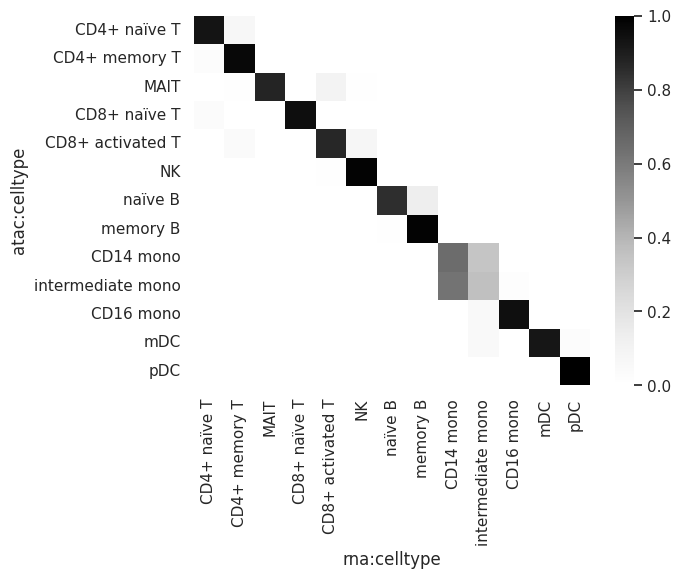

<IPython.core.display.Javascript object>

In [11]:
sns.heatmap(df_wide, cmap="Greys")

It seems that cell types are highly reproducible across modalities with the only exception of the CD14/intermediate monocytes annotation that doesn't seem particularly confident — most probably in the ATAC modality. One can check that the adjusted Rand index goes up to `0.92` when those two groups of cells are treated as one cell types.

## Multimodal Integration

In [12]:
# subset only highly variable features
mu.pp.filter_var(mdata, "highly_variable")
mdata

MuData object with n_obs × n_vars = 9534 × 17922
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    atac:	9534 x 14896
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9534 x 3026
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

<IPython.core.display.Javascript object>

Perform a simple preprocessing by centering the data and keeping only the 6000 most variable genes from the RNA-seq dataset, instead of ~15K. Finally, update the `MuData` object.

In [13]:
top_k_var = 6000
for view_name, adata in mdata.mod.items():

    ordered_feature_subset = np.nanvar(adata.X, axis=0).argsort()[::-1]
    print(
        f"Ordering features by variance in descending order, and keeping only top {top_k_var}"
    )
    adata._inplace_subset_var(adata.var_names[ordered_feature_subset[:top_k_var]])

    print(f"Current shape of {view_name}: {adata.shape}")
    print("Centering features")
    adata.X -= np.nanmean(adata.X, axis=0)
    global_std = np.nanstd(adata.X)
    print(f"Global std of {view_name} before: {global_std}")
    adata.X /= global_std
    print(f"Global std of {view_name}: {np.nanstd(adata.X)}")

mdata.update()

Ordering features by variance in descending order, and keeping only top 6000
Current shape of atac: (9534, 6000)
Centering features
Global std of atac before: 1.0062228441238403
Global std of atac: 1.0000025033950806
Ordering features by variance in descending order, and keeping only top 6000
Current shape of rna: (9534, 3026)
Centering features
Global std of rna before: 0.9799867272377014
Global std of rna: 1.0000003576278687


/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


<IPython.core.display.Javascript object>

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of features from both modalities.

In [14]:
measured_pathways, pathway_df = muvi.fs.load_pathways(
    # h.all -> hallmark
    # c2.cp.reactome -> reactome
    ["h.all", "c2.cp.reactome"],
    mdata.var_names,
    fraction_available=0.1,
    min_gene_count=15,
    msigdb_version="7.5.1",
)
measured_pathways = measured_pathways.merge_duplicates()
measured_pathways

2023-02-08 14:00:28,610 - muvi.tools.feature_sets - INFO - Loading collection h.all with at least 10.0% of genes available and at least 15 genes
2023-02-08 14:00:28,619 - muvi.tools.feature_sets - INFO - Loaded 34 pathways from collection h.all with median size of 28.5 genes
2023-02-08 14:00:28,620 - muvi.tools.feature_sets - INFO - Loading collection c2.cp.reactome with at least 10.0% of genes available and at least 15 genes
2023-02-08 14:00:28,669 - muvi.tools.feature_sets - INFO - Loaded 134 pathways from collection c2.cp.reactome with median size of 25.0 genes
2023-02-08 14:00:28,670 - muvi.tools.feature_sets - INFO - Loaded in total 168 pathways with median size of 25.0 genes


<GeneSets with 168 gene sets>

<IPython.core.display.Javascript object>

Plot the distribution of each gene set size grouped by each gene set collection.

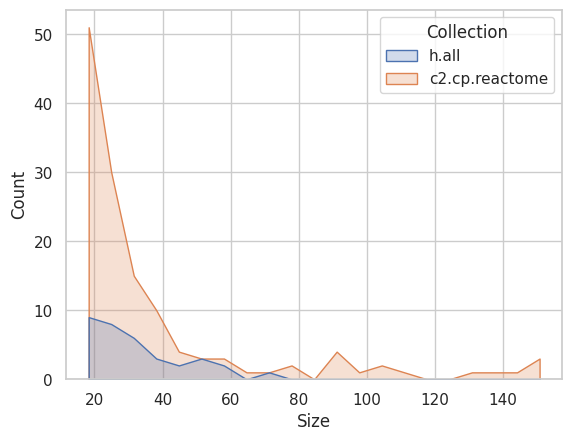

<IPython.core.display.Javascript object>

In [15]:
sns.histplot(
    pd.concat(pathway_df).reset_index(), x="Size", hue="Collection", element="poly"
)
plt.show()

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In our case, we may only inform the RNA view, and expect the ATAC view to be informed implicitly during the inference of shared latent factors.

Finally, we convert the prior information into a numerical representation such as a binary matrix.

In [16]:
adata = mdata["rna"]
gene_set_mask, gene_sets = measured_pathways.to_mask(adata.var_names.tolist())

adata.uns["gene_set_name"] = [gsn.name for gsn in gene_sets]

adata.varm["gene_set_mask"] = pd.DataFrame(
    gene_set_mask.astype("bool").T,
    index=adata.var_names,
    columns=adata.uns["gene_set_name"],
)

mdata.uns["gene_set_name"] = adata.uns["gene_set_name"]

<IPython.core.display.Javascript object>

Create a `MuVI` model directly from the `MuData` object by providing the necessary arguments such as the `varm` key for the numerically encoded prior information of the gene set annotations.

In [17]:
model = muvi.tl.from_mdata(
    mdata, prior_mask_key="gene_set_mask", view_names=["rna", "atac"]
)

2023-02-08 14:00:29,256 - muvi.tools.utils - WARNING - No prior information found for `atac`.
2023-02-08 14:00:29,259 - muvi.core.models - INFO - pd.DataFrame detected.
2023-02-08 14:00:29,260 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2023-02-08 14:00:29,262 - muvi.core.models - INFO - pd.DataFrame detected.
2023-02-08 14:00:29,264 - muvi.core.models - INFO - pd.DataFrame detected.
2023-02-08 14:00:29,265 - muvi.core.models - INFO - pd.DataFrame detected.
2023-02-08 14:00:29,265 - muvi.core.models - INFO - pd.DataFrame detected.
2023-02-08 14:00:29,266 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2023-02-08 14:00:29,268 - muvi.core.models - INFO - Mask for view `atac` not found, assuming `atac` to be uninformed.
2023-02-08 14:00:29,274 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal', 'atac': 'normal'}`
2023-02-08 14:00:29,315 - muvi.core.models - INFO - GPU available, running all computations on

<IPython.core.display.Javascript object>

Train the model using stochastic variational inference (SVI) in order to utilize smaller batches of the whole dataset to avoid loading the whole dataset onto the GPU. The training takes around 7 minutes on a single Quadro RTX 5000 NVIDIA GPU.

In [18]:
n_epochs = 500
loss_history, _ = model.fit(
    batch_size=1000,
    n_epochs=n_epochs,
    n_particles=1,
    learning_rate=0.005,
    optimizer="clipped",
    verbose=1,
    seed=0,
)

2023-02-08 14:00:29,325 - muvi.core.models - INFO - Using 1 particles in parallel
2023-02-08 14:00:29,327 - muvi.core.models - INFO - Preparing model and guide...
2023-02-08 14:00:31,697 - muvi.core.models - INFO - Preparing optimizer...
2023-02-08 14:00:31,699 - muvi.core.models - INFO - Decaying learning rate over 4500 iterations.
2023-02-08 14:00:31,700 - muvi.core.models - INFO - Preparing SVI...
2023-02-08 14:00:31,701 - muvi.core.models - INFO - Preparing training data...
2023-02-08 14:00:31,855 - muvi.core.models - INFO - Using batches of size `1000`.
2023-02-08 14:00:31,858 - muvi.core.models - INFO - Setting training seed to `0`
2023-02-08 14:00:31,859 - muvi.core.models - INFO - Cleaning parameter store
2023-02-08 14:00:31,861 - muvi.core.models - INFO - Starting training...


  0%|                                                                                                               | 0/500 [00:00<?, ?it/s]

2023-02-08 14:00:32,486 - root - INFO - Guessed max_plate_nesting = 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:06<00:00,  1.17it/s, ELBO=1.26e+5]


<IPython.core.display.Javascript object>

## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

2023-02-08 14:07:38,465 - muvi.tools.utils - INFO - Estimating r2 with a random sample of 1000 samples.
2023-02-08 14:07:38,597 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/projects/muvi_outer/muvi/muvi/tools/cache.py:84: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.factor_adata.varm[Cache.META_KEY].update(scores)


<AxesSubplot: >

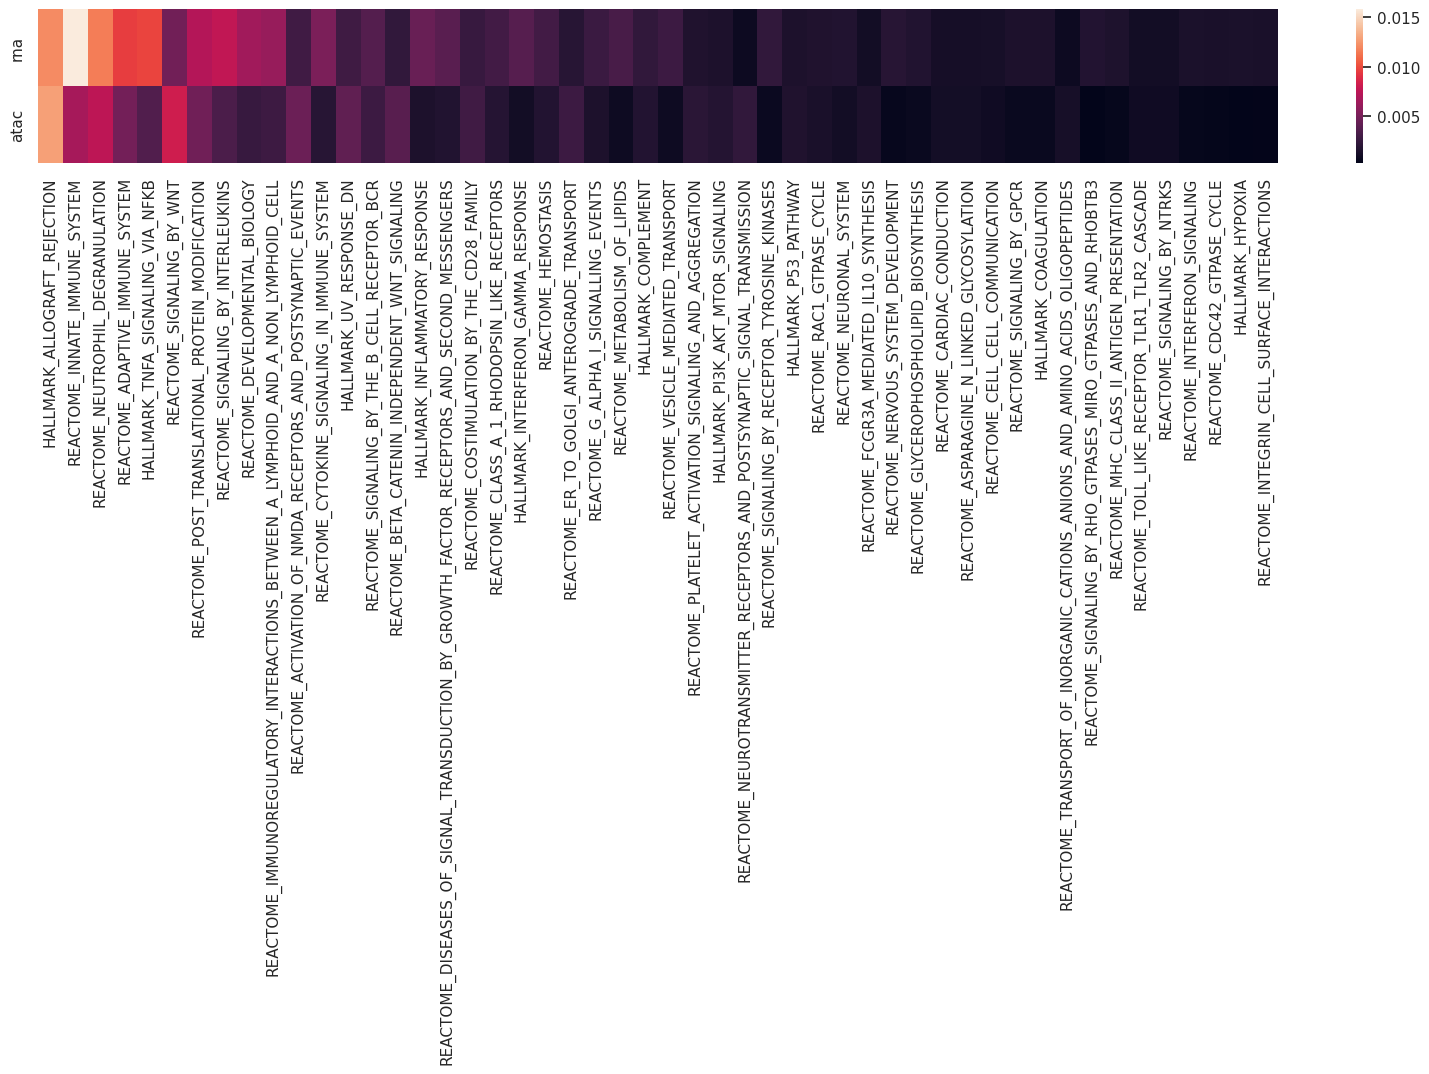

<IPython.core.display.Javascript object>

In [19]:
# to speed up the process, use a random subsample to approximate the variance explained
muvi.tl.variance_explained(model, subsample=1000)
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation. Since we only inform the RNA view, we may not apply this function on the uninformed views such as the ATAC view in our case.

In [20]:
for sign in ["neg", "pos"]:
    muvi.tl.test(model, view_idx="rna", sign=sign)

2023-02-08 14:07:48,446 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:11<00:00, 14.38it/s]


2023-02-08 14:08:00,519 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:11<00:00, 14.40it/s]


<IPython.core.display.Javascript object>

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

For the uninformed views, i.e. ATAC, we omit any information regarding the statistical testing, and only sort the factors by their corresponding variance explained.

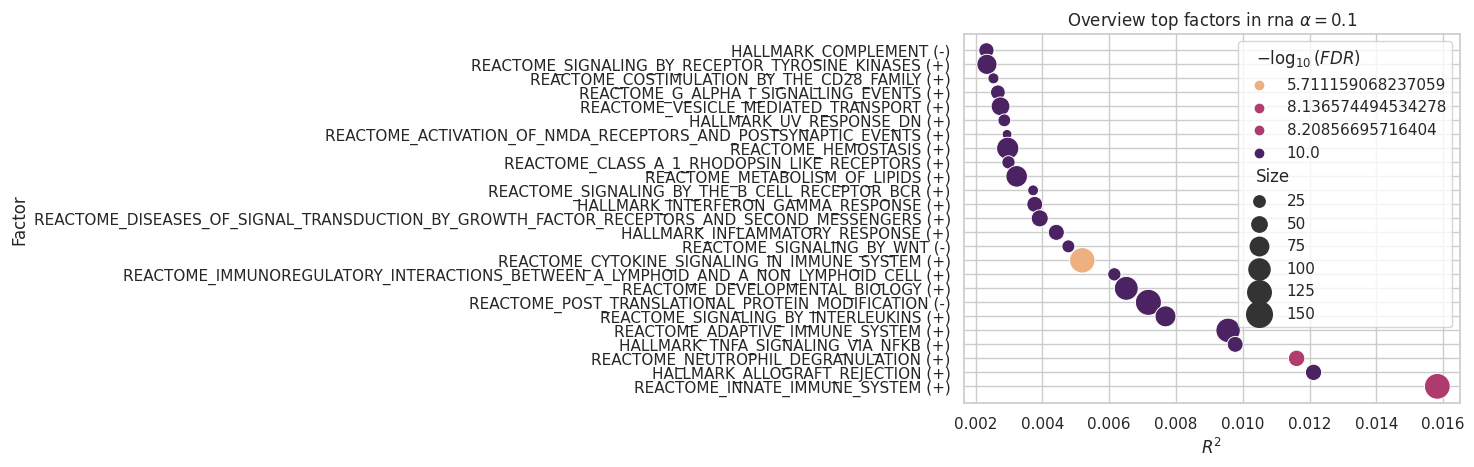

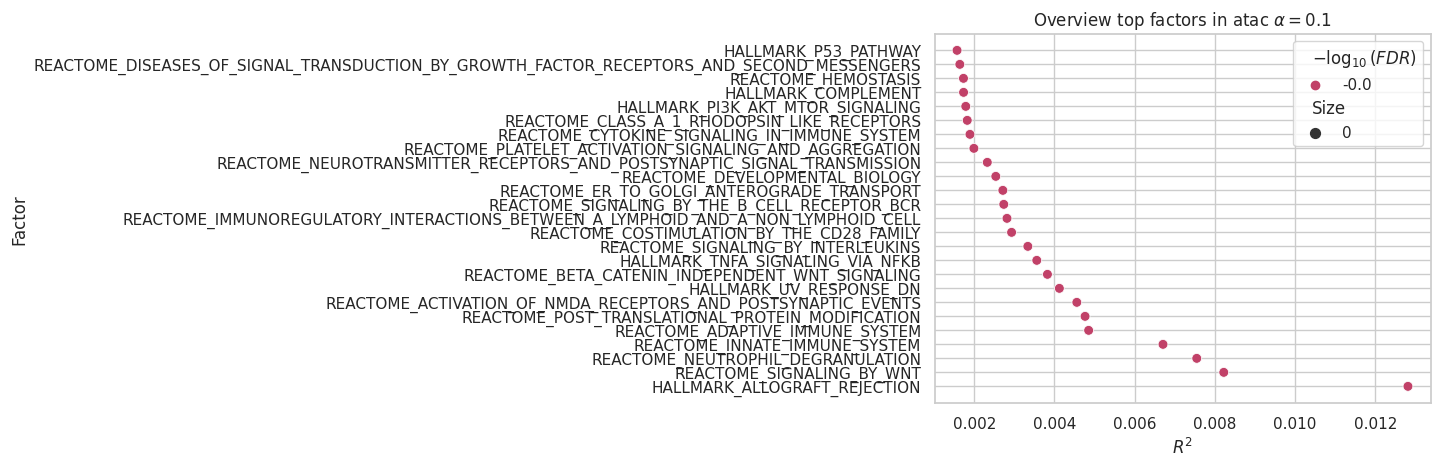

<IPython.core.display.Javascript object>

In [21]:
for vn in model.view_names:
    muvi.pl.factors_overview(
        model,
        vn,
        one_sided=True,
        alpha=0.1,
        sig_only=False,
        adjusted=True,
        sort=25,
        show=True,
    )

In [22]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()
# copy predefined colors
model._cache.factor_adata.uns["rna:celltype_colors"] = mdata["rna"].uns[
    "celltype_colors"
]
model._cache.factor_adata.uns["atac:celltype_colors"] = mdata["atac"].uns[
    "celltype_colors"
]

<IPython.core.display.Javascript object>

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [23]:
muvi.tl.filter_factors(model, r2_thresh=0.9)

2023-02-08 14:08:14,169 - muvi.tools.utils - INFO - Filtering down to 90 factors.
2023-02-08 14:08:14,173 - muvi.tools.cache - INFO - Factors filtered successfully.


<IPython.core.display.Javascript object>

In [24]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

<IPython.core.display.Javascript object>

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


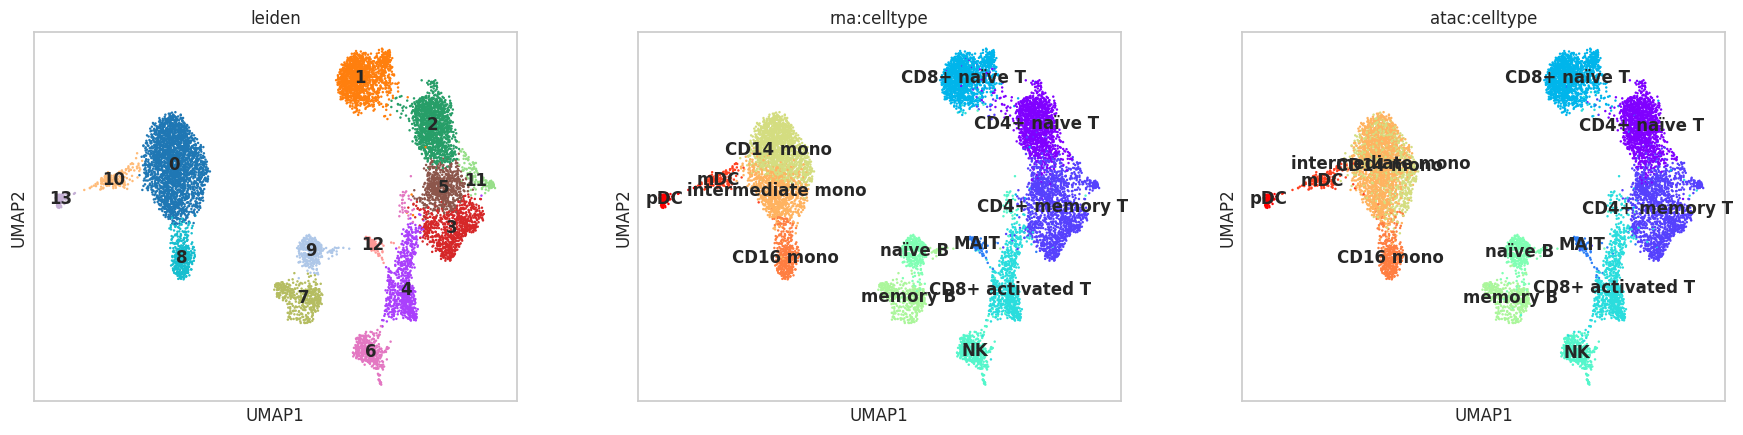

<IPython.core.display.Javascript object>

In [25]:
groupby = "leiden"
color = [groupby] + ["rna:celltype", "atac:celltype"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [26]:
muvi.tl.rank(model, "rna:celltype", method="wilcoxon")

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'log

<IPython.core.display.Javascript object>

2023-02-08 14:08:51,437 - muvi.tools.plotting - WARNING - dendrogram data not found (using key=%s). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


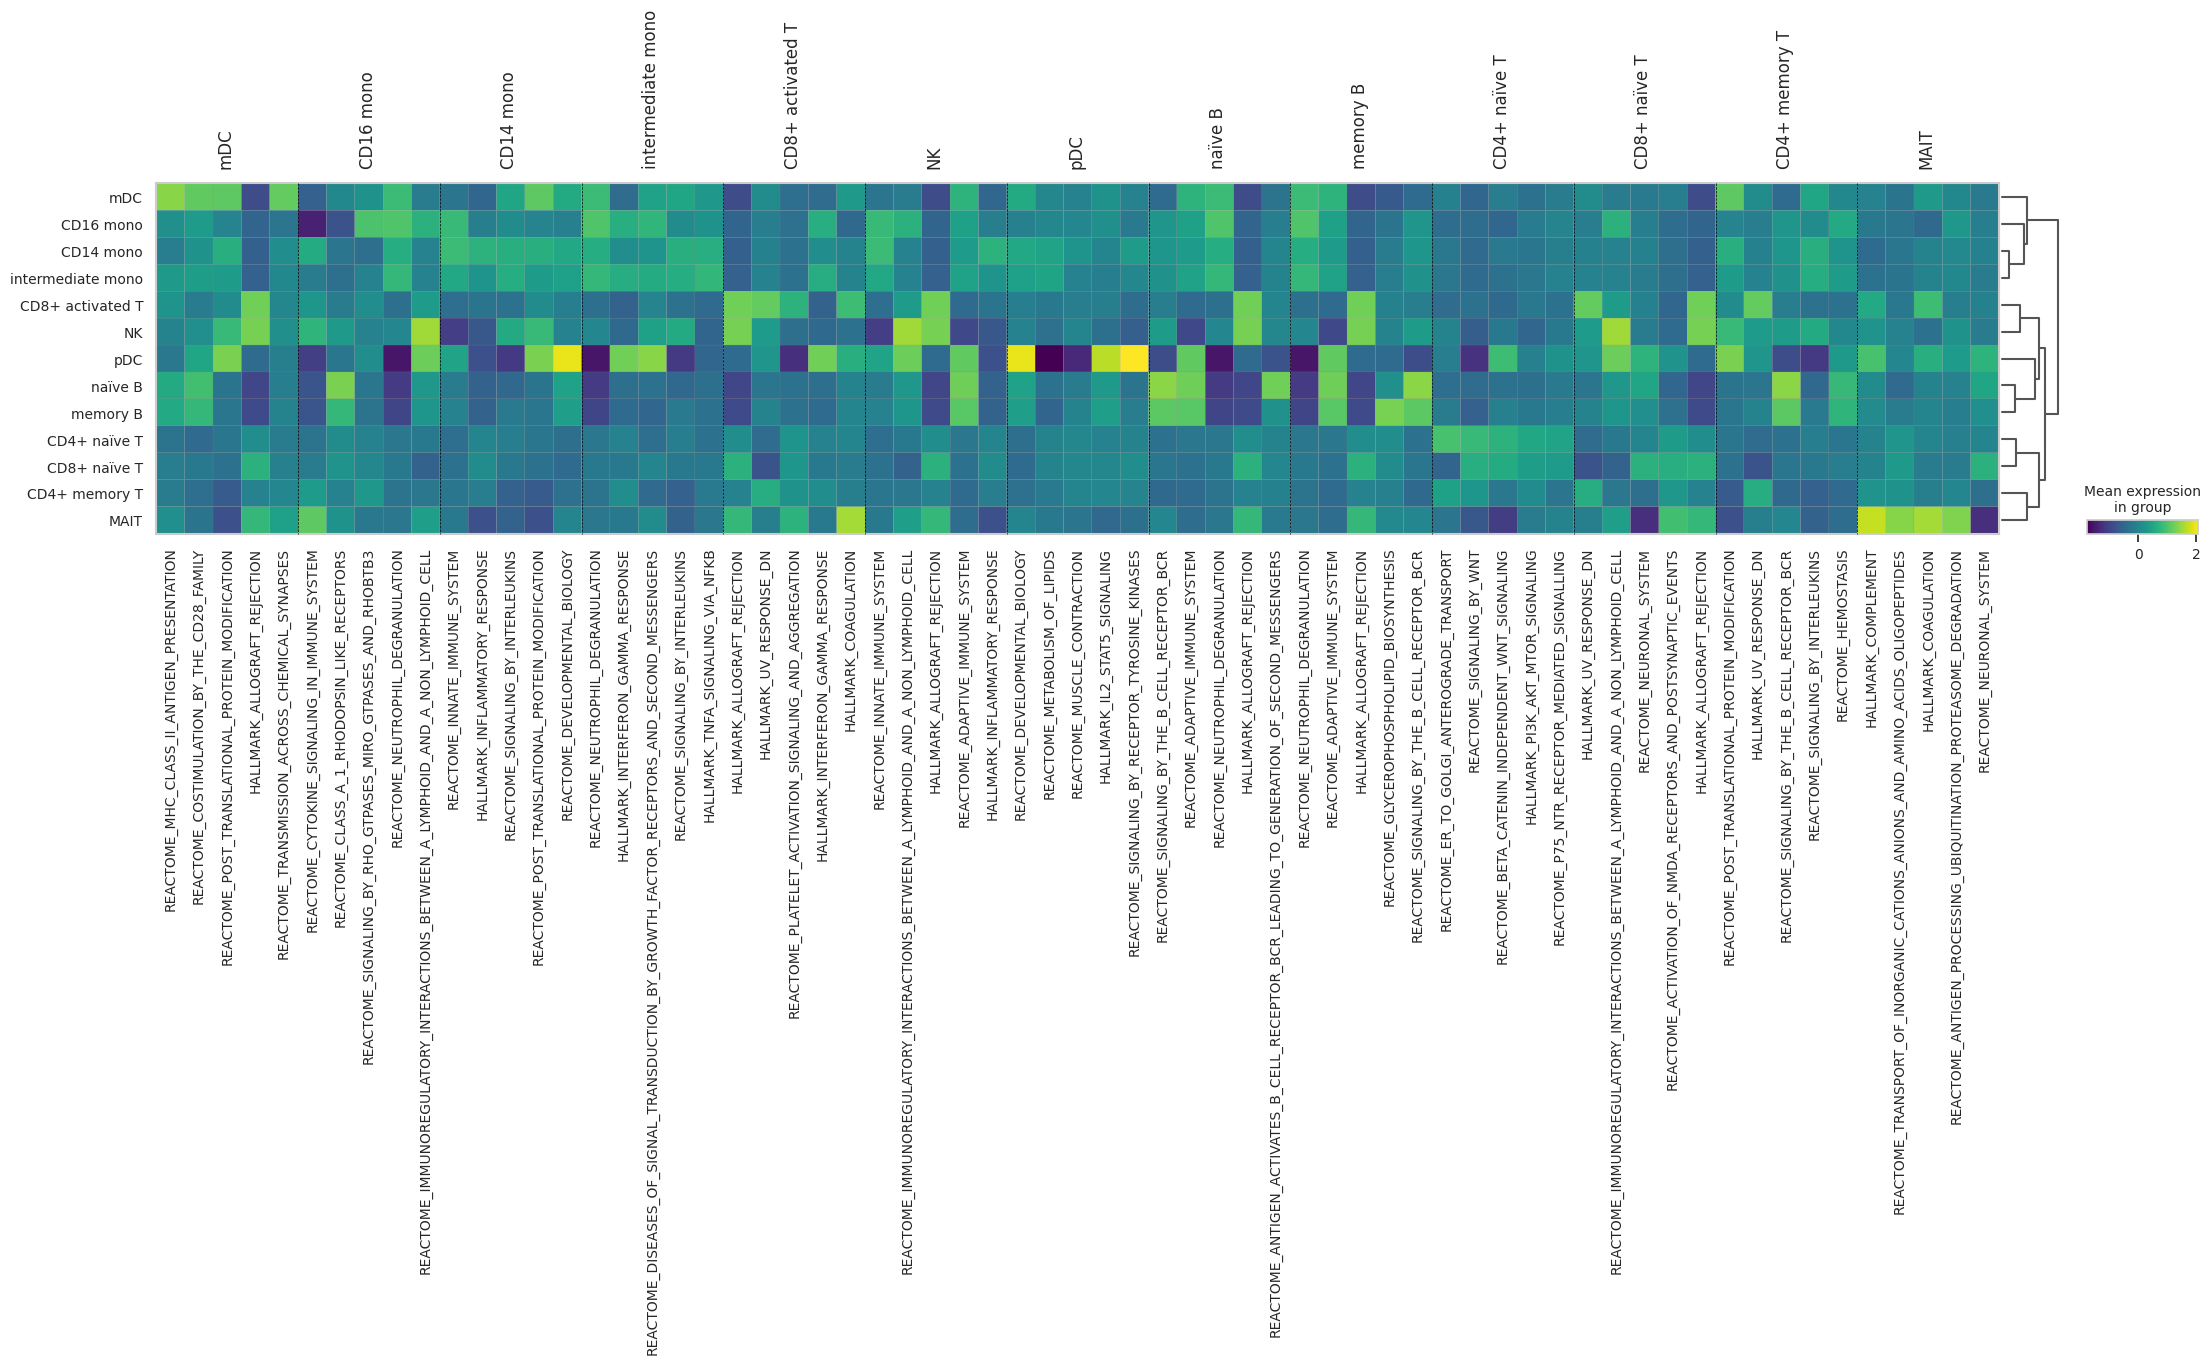

<IPython.core.display.Javascript object>

In [27]:
muvi.pl.rank(model, n_factors=5, pl_type="matrixplot")

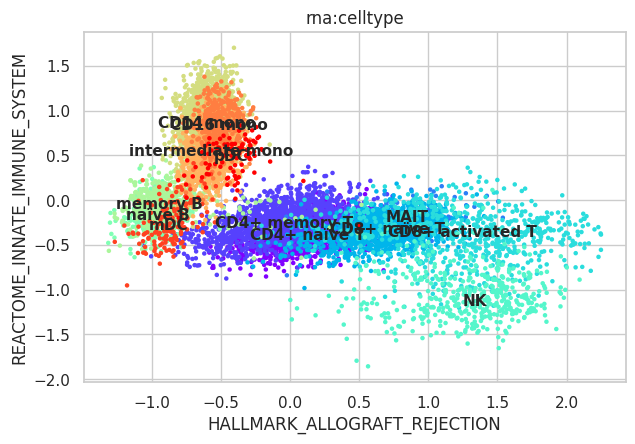

<IPython.core.display.Javascript object>

In [28]:
# top two factors based on variance explained
muvi.pl.scatter(
    model,
    "HALLMARK_ALLOGRAFT_REJECTION",
    "REACTOME_INNATE_IMMUNE_SYSTEM",
    "rna:celltype",
    size=42,
    legend_loc="on data",
)

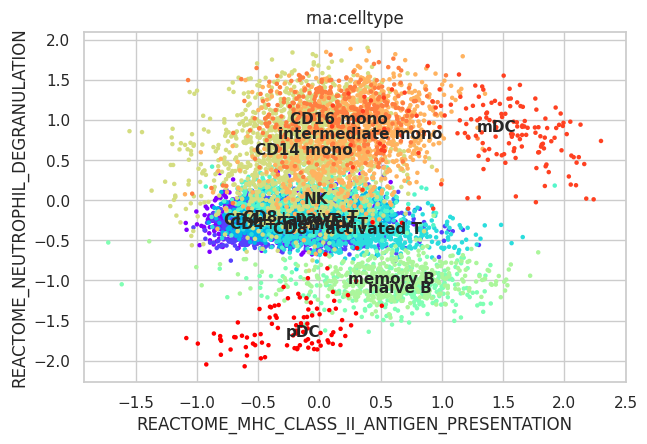

<IPython.core.display.Javascript object>

In [29]:
# pathways relevant for mDCs and pDCs
muvi.pl.scatter(
    model,
    "REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION",
    "REACTOME_NEUTROPHIL_DEGRANULATION",
    "rna:celltype",
    size=42,
    legend_loc="on data",
)

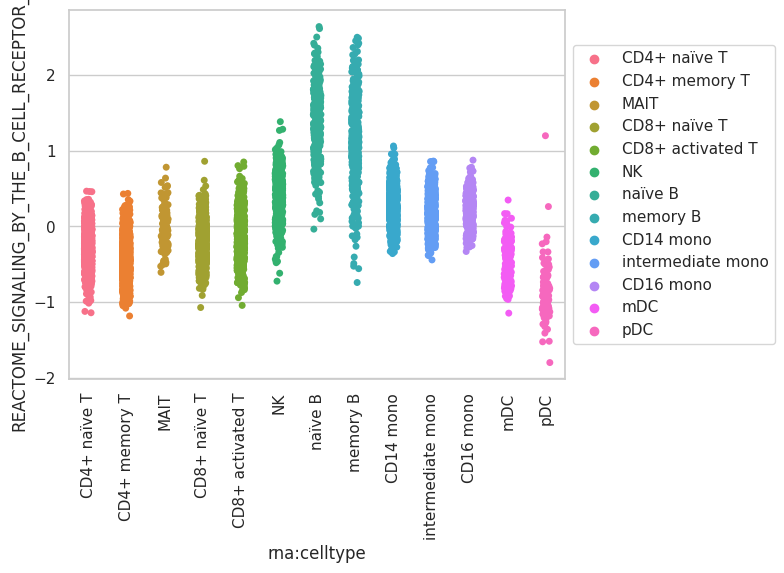

<IPython.core.display.Javascript object>

In [30]:
# main pathway relevant for B cells
muvi.pl.stripplot(
    model, "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR", "rna:celltype"
)
plt.xticks(rotation=90)
plt.show()

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

<AxesSubplot: title={'center': 'Overview factor REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR in rna'}, xlabel='Loading', ylabel='Feature'>

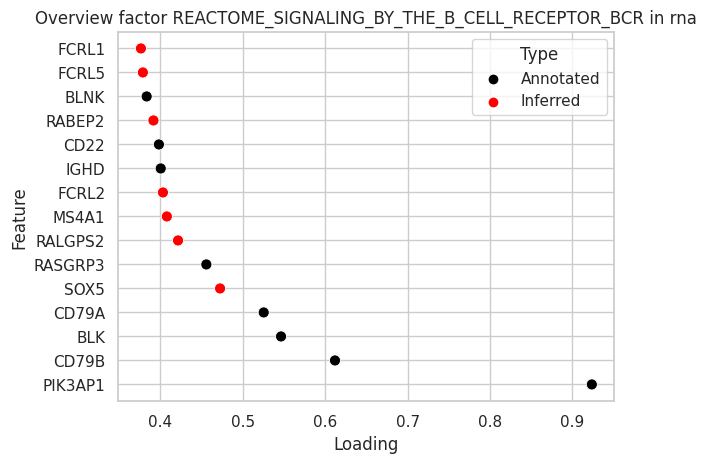

<IPython.core.display.Javascript object>

In [31]:
muvi.pl.inspect_factor(
    model,
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    "rna",
    sort=15,
)

We may go further and inspect the factor loadings of the main factors in each view, or even pick out the shared factors to better understand the relationship between both views.

In [32]:
def plot_top_factors(r2_factor, n_rows=2, n_cols=2, view_idx="rna", sort=20):
    both_views = isinstance(view_idx, list)
    r2_df = r2_factor.sum(1)
    if both_views:
        n_cols = model.n_views
    else:
        r2_df = r2_factor[f"r2_{view_idx}"]
    r2_sorted = r2_df.sort_values(ascending=False)
    fig, axs = plt.subplots(
        n_rows, n_cols, squeeze=False, figsize=(n_cols * 5, n_rows * 5)
    )

    for i in range(n_rows):
        for j in range(n_cols):
            k = i * n_cols + j
            factor_idx = r2_sorted.index[k]
            if both_views:
                factor_idx = r2_sorted.index[i]
            ax = axs[i, j]
            # only last
            show_legend = k == n_rows * n_cols - 1
            view_name = view_idx
            ax_title = factor_idx
            if both_views:
                view_name = view_idx[j]
                ax_title = view_name + ": " + ax_title

            ax_title += f" ({r2_factor.loc[factor_idx, 'r2_' + view_name]:.3f})"
            muvi.pl.inspect_factor(
                model, factor_idx, view_name, sort=sort, ax=ax, legend=show_legend
            )
            ax.set_title(ax_title)
    return fig, axs

<IPython.core.display.Javascript object>

In [33]:
r2_factor = model._cache.factor_metadata[[f"r2_{vn}" for vn in model.view_names]]

<IPython.core.display.Javascript object>

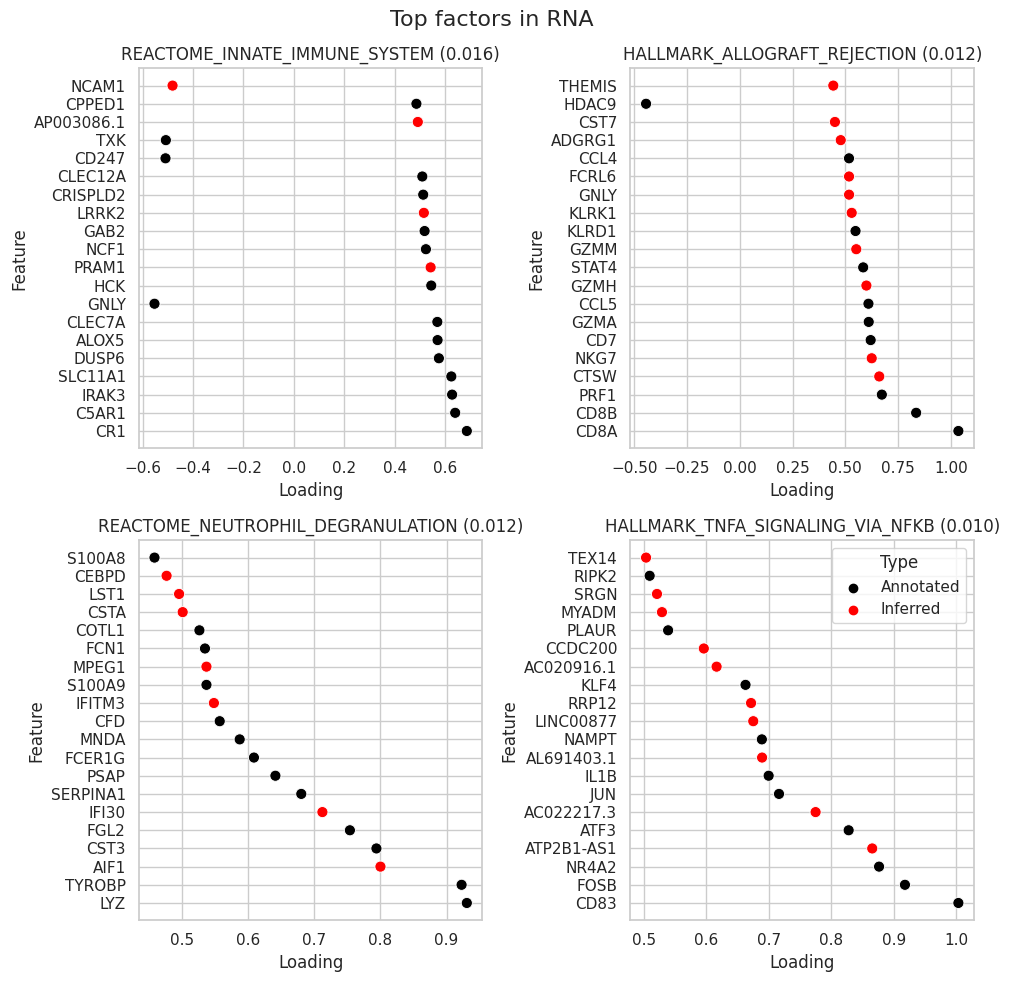

<IPython.core.display.Javascript object>

In [34]:
fig, axs = plot_top_factors(
    r2_factor,
    view_idx="rna",
)
fig.suptitle("Top factors in RNA", fontsize=16)
fig.tight_layout()
plt.show()

Optionally, we can map peaks to gene symbols for better readability. Mapping file [pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv](https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv) downloaded from 10x Genomics.

In [35]:
atac_df = pd.read_csv(
    "pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv", sep="\t", index_col=0
)
atac_df["gene"] = atac_df["gene"].str.split(";").str[0]
s = atac_df.index.str.split("_")
atac_df.index = s.str[0] + ":" + s.str[1] + "-" + s.str[2]
mapping_dict = {k: f"{k[:10]}.. ({v})" for k, v in atac_df["gene"].to_dict().items()}
# mapping_dict
model.feature_names["atac"] = mdata["atac"].var_names.map(mapping_dict)

<IPython.core.display.Javascript object>

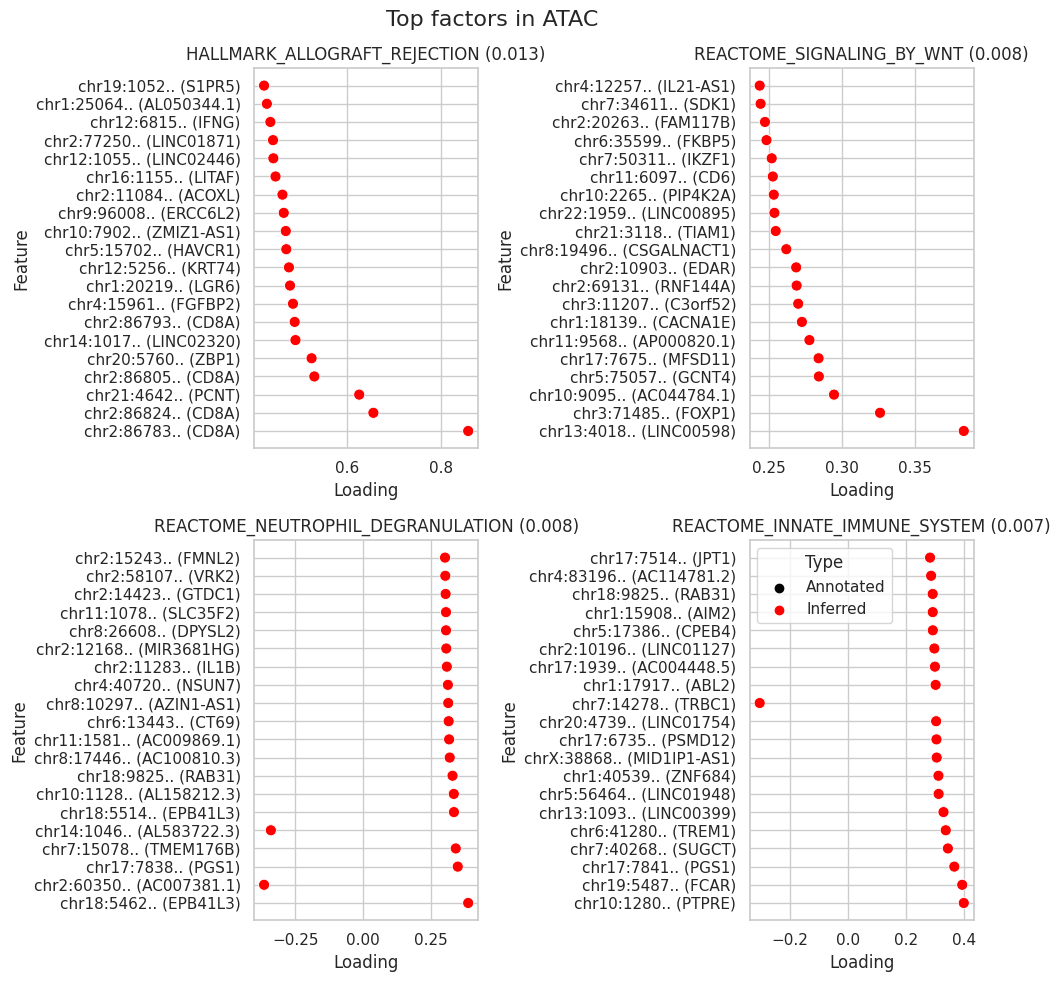

<IPython.core.display.Javascript object>

In [36]:
fig, axs = plot_top_factors(
    r2_factor,
    view_idx="atac",
)
fig.suptitle("Top factors in ATAC", fontsize=16)
fig.tight_layout()
plt.show()

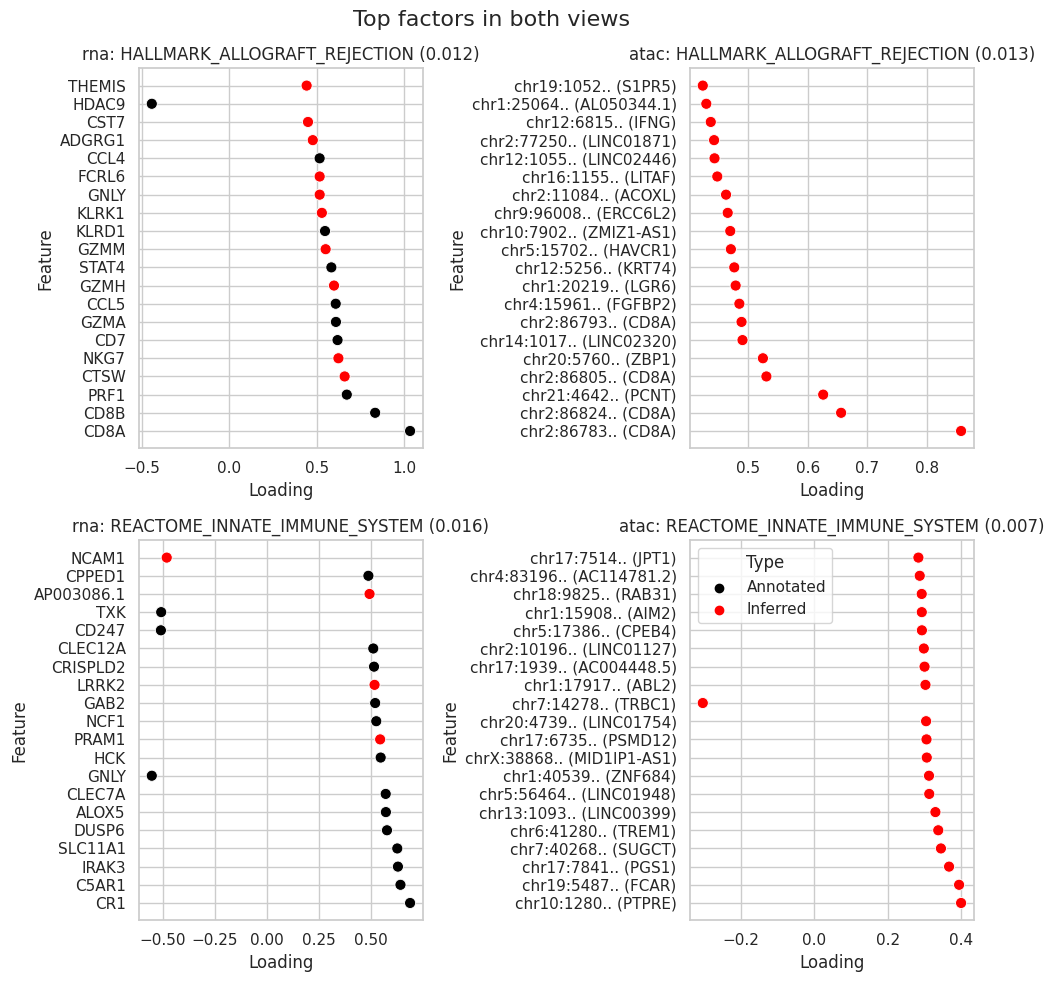

<IPython.core.display.Javascript object>

In [37]:
fig, axs = plot_top_factors(r2_factor, view_idx=["rna", "atac"])
fig.suptitle("Top factors in both views", fontsize=16)
fig.tight_layout()
plt.show()

The shared factor `ALLOGRAFT_REJECTION`, for instance, shares `CD8A` in the top loadings across both views. Recall that we informed only the RNA.

## Saving & Loading MuVI Models

Once we are finished with the analysis, we may save and load the `MuVI` model on disk with `muvi.save` and `muvi.load`, respectively.

In [38]:
# muvi.save(model)

<IPython.core.display.Javascript object>